In [1]:
from ecoevocrm.consumer_resource_system import *
import ecoevocrm.utils as utils
import ecoevocrm.viz as viz
import ecoevocrm.coarse_graining as cg

In [2]:
import matplotlib.pyplot as plt

In [3]:
import cProfile
import pstats

--------

### Set the number of resources

In [4]:
L = 40

### Define the ancestral phenotype (traits vector)

In [5]:
anc_phenotype = utils.random_matrix(shape=(1, L), mode='binomial')

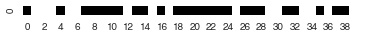

In [6]:
viz.matrix_plot(anc_phenotype)

### Define the system biochemistry (trait/resource interactions)

In [7]:
J = utils.random_matrix((L, L), 'tikhonov_sigmoid')

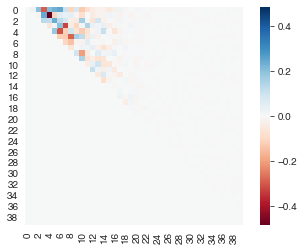

In [8]:
viz.matrix_plot(J)

### Parameterize and instantiate the Consumer-Resource System

In [9]:
anc_system = ConsumerResourceSystem(sigma=anc_phenotype, 
                                    b=1, k=1e10, c=0.1, chi=0.5, J=J, mu=1e-10,
                                    resource_consumption_mode='fast_resource_eq',
                                    resource_inflow_mode='none',
                                    threshold_min_rel_abundance=1e-6,
                                    N_init=1, R_init=1)

### Simulate dynamics

In [10]:
# just to pre-compile the dynamics njit function
# anc_system.dynamics(*((0,) + (np.zeros(L+L+1),) + anc_system.get_params()))

In [11]:
# anc_system.run(T=1000)

In [12]:
%load_ext line_profiler

In [13]:
# %lprun -f anc_system.dynamics anc_system.run(T=1000)
# %lprun -f anc_system.handle_mutation_event anc_system.run(T=1000)

In [14]:
profiler = cProfile.Profile()
# %lprun -f anc_system.dynamics profiler.runcall(anc_system.run)
# %lprun -f ConsumerResourceSystem.growth_rate profile.runcall(anc_system.run)
# %lprun -f anc_system.event_low_abundance profiler.runcall(anc_system.run)
%lprun -f TypeSet.add_type profiler.runcall(anc_system.run)
# %lprun -f TypeSet.generate_mutant_set profiler.runcall(anc_system.run)

Timer unit: 1e-06 s

Total time: 85.81 s
File: /Users/ryan/Dropbox/Projects/ResearchProjects/eco-evo-crm/ecoevocrm/src/ecoevocrm/type_set.py
Function: add_type at line 129

Line #      Hits         Time  Per Hit   % Time  Line Contents
   129                                               def add_type(self, type_set=None, sigma=None, b=None, k=None, eta=None, l=None, g=None, c=None, chi=None, mu=None, index=None, parent_index=None, parent_id=None):
   130      3544       6398.0      1.8      0.0          new_type_idx = index if index is not None else self.num_types # default to adding to end of matrices
   131      3544       6119.0      1.7      0.0          ref_type_idx = new_type_idx - 1
   132      3544       3848.0      1.1      0.0          parent_idx   = np.where(self.type_ids==parent_id)[0] if parent_id is not None else parent_index
   133                                                   #----------------------------------
   134      3544       3437.0      1.0      0.0        

In [15]:
ps = pstats.Stats(profiler)
ps.sort_stats('tottime')
ps.print_stats()

         4446813 function calls (4445028 primitive calls) in 510.469 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
    98603  162.920    0.002  162.920    0.002 {built-in method numpy.concatenate}
    38984  160.427    0.004  162.004    0.004 /usr/local/lib/python3.8/site-packages/numpy/lib/function_base.py:5143(insert)
    45553   42.829    0.001   70.387    0.002 /Users/ryan/Dropbox/Projects/ResearchProjects/eco-evo-crm/ecoevocrm/src/ecoevocrm/consumer_resource_system.py:305(growth_rate)
    91106   26.742    0.000   26.742    0.000 {built-in method numpy.core._multiarray_umath.c_einsum}
        1   23.618   23.618  510.469  510.469 /Users/ryan/Dropbox/Projects/ResearchProjects/eco-evo-crm/ecoevocrm/src/ecoevocrm/consumer_resource_system.py:181(run)
     2959   13.766    0.005   14.024    0.005 {method 'choice' of 'numpy.random.mtrand.RandomState' objects}
     1772   12.344    0.007  185.934    0.105 /Users/ryan/Dropbo

### Visualize results

In [16]:
type_colors = viz.color_types_by_phylogeny(anc_system.type_set, apply_palette_depth=1)

<AxesSubplot:>

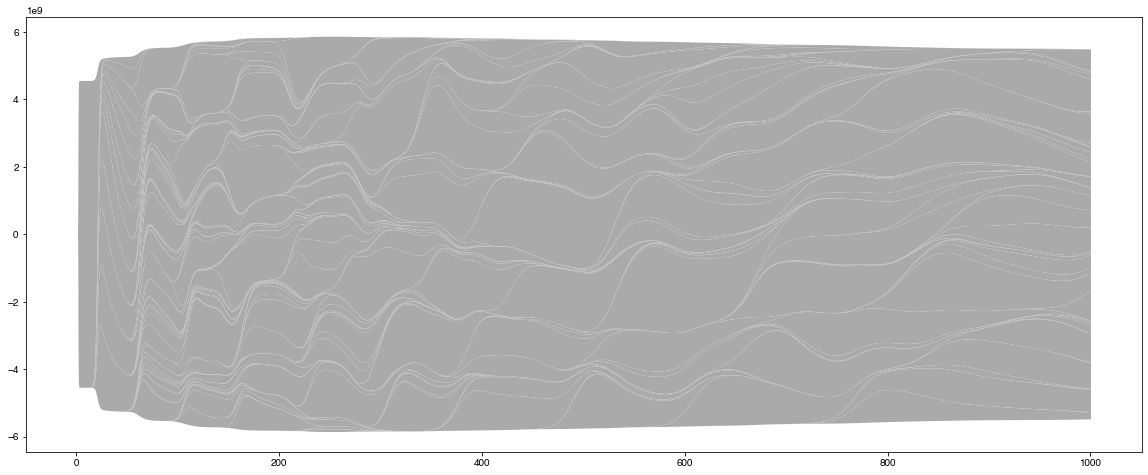

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(20, 8))
viz.stacked_abundance_plot(anc_system, ax=ax, type_colors=type_colors)

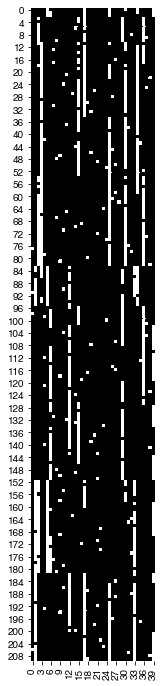

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(3, 12))
viz.matrix_plot(anc_system.get_extant_type_set().sigma, ax=ax)

In [19]:
anc_system.type_set.mutant_set.sigma.shape

(70920, 40)

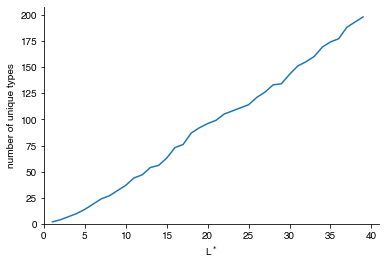

In [20]:
viz.Lstar_types_plot(anc_system)

In [21]:
N_end = anc_system.N_series[:,-1]
np.count_nonzero((N_end > 0) & (N_end < 1e4))

128

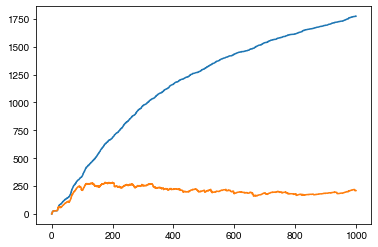

In [31]:
plt.plot(anc_system.t_series, n)
plt.plot(anc_system.t_series, (anc_system.N_series > 0).sum(axis=0))

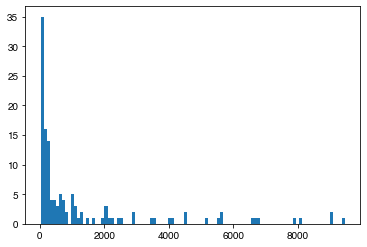

In [36]:
plt.hist(anc_system.N_series[(anc_system.N_series[:,-1]>0)&(anc_system.N_series[:,-1]<1e4),-1], bins=100)
# plt.xlim((0,100))
plt.show()

In [23]:
# anc_system.mutant_fitnesses[(anc_system.N_series[:,-1] > 0) & (anc_system.N_series[:,-1] < 1e4)]
# ConsumerResourceSystem.growth_rate()
anc_system.N()

array([0., 0., 0., ..., 0., 0., 0.])

In [24]:
r = ConsumerResourceSystem.growth_rate(anc_system.N()[:, np.newaxis], anc_system.R(), anc_system.type_set.sigma, anc_system.type_set.b, anc_system.type_set.k, anc_system.type_set.eta, anc_system.type_set.l, anc_system.type_set.g, anc_system.type_set.energy_costs, anc_system.resource_set.omega, anc_system.resource_consumption_mode)

In [34]:
r[(anc_system.N() > 0) & (anc_system.N() < 1e4)] - np.mean(r[r > 0])

array([ 0.00561794,  0.04559206,  0.0056182 ,  0.00561818,  0.00561811,
       -0.0180401 ,  0.0213671 , -0.02005485, -0.02005438, -0.02793825,
       -0.0027412 , -0.00276388, -0.01474133, -0.01474139, -0.01474135,
       -0.0147413 , -0.01474143,  0.02306785, -0.01474153, -0.01474132,
       -0.01474154,  0.03362029, -0.00418886, -0.00418893,  0.09445078,
        0.06041523, -0.00418893, -0.00418917, -0.00418899, -0.0041891 ,
       -0.00419312, -0.00418901, -0.00418926,  0.03191955, -0.00748813,
       -0.01732117, -0.01732103,  0.02208614, -0.01732118, -0.01732104,
        0.02048811, -0.01732119, -0.01732105, -0.01732135, -0.01732106,
       -0.01732144, -0.01732112, -0.01732286, -0.01732111, -0.01732111,
       -0.0173211 , -0.01732117, -0.01732127, -0.0173253 ,  0.01474691,
        0.01474686, -0.01443988, -0.01443994, -0.01444163, -0.01443989,
       -0.01591634, -0.0159164 ,  0.02772787, -0.01591681, -0.01591655,
        0.05024482,  0.032156  , -0.01148832, -0.01148826, -0.01

In [26]:
r[r<0]

array([-1.16880771, -0.65635496, -0.65635495, ..., -0.57069295,
       -0.57069721, -0.65635518])

In [27]:
anc_system.type_set.sigma.shape

(1773, 40)

In [28]:
a = np.where(anc_system.N_series > 0)

In [29]:
a = (anc_system.N_series > 0).argmax(axis=1)

In [30]:
n = []
for t_idx in range(anc_system.t_series.shape[0]):
    n.append(np.count_nonzero(a <= t_idx))              

In [32]:
anc_system.get_extant_types()


array([ 153,  156,  158,  254,  255,  257,  258,  259,  260,  261,  262,
        276,  325,  326,  332,  333,  334,  335,  347,  359,  361,  362,
        363,  368,  369,  370,  371,  372,  373,  374,  375,  376,  377,
        378,  379,  381,  382,  383,  384,  385,  386,  387,  388,  389,
        390,  391,  392,  393,  394,  395,  396,  397,  410,  411,  412,
        420,  421,  422,  423,  424,  430,  431,  432,  433,  434,  435,
        436,  437,  438,  439,  440,  441,  442,  443,  444,  445,  446,
        447,  448,  449,  450,  451,  452,  638,  648,  651,  653,  654,
        656,  657,  658,  659,  662,  663,  665,  667, 1082, 1087, 1088,
       1089, 1090, 1091, 1093, 1102, 1103, 1104, 1105, 1106, 1107, 1108,
       1109, 1110, 1111, 1112, 1113, 1114, 1115, 1116, 1117, 1118, 1119,
       1120, 1121, 1122, 1123, 1124, 1125, 1128, 1139, 1140, 1149, 1150,
       1151, 1152, 1153, 1154, 1155, 1156, 1157, 1158, 1159, 1160, 1161,
       1162, 1164, 1169, 1170, 1176, 1177, 1178, 11